In [1]:
import torch
from torch import nn #neural network
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu117'

### Data Prep and Loading

In [2]:
weight = 0.7 #b
bias = 0.3 #a

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #unsqueeze: add dimension
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Spilting data into training and test sets

In [3]:
#Creat a train test spilt

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

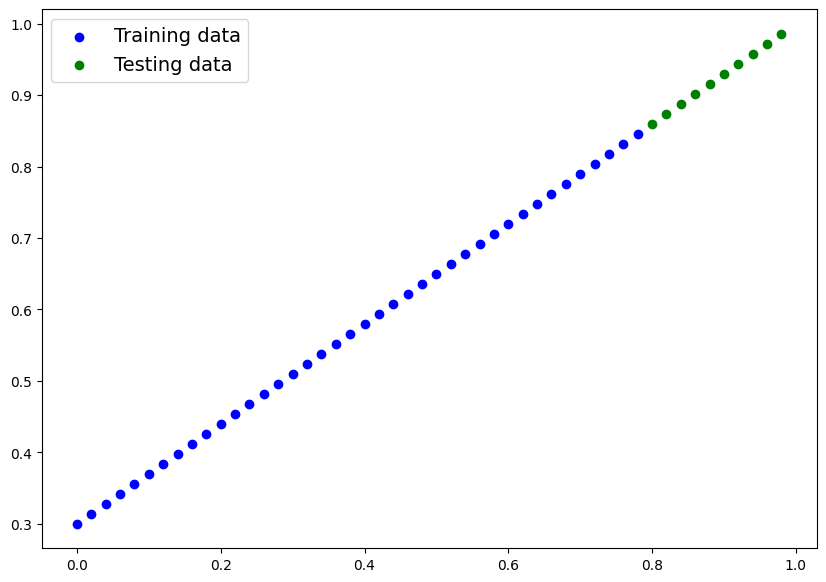

In [4]:
#We need to visualize the data

def plot_predict(train_data=X_train,
                train_labels=y_train,
                test_data=X_test,
                test_labels=y_test,
                predictions=None):
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c='b', label='Training data') #train in blue

    plt.scatter(test_data, test_labels, c='g', label='Testing data') #test in green

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', label='Predictions') #predictions in red

    plt.legend(prop={"size": 14})

plot_predict()

### Building first pytorch model

In [5]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### Model Building Essentials

nn.Module contains the larger building blocks (layers)

nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))

forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)

torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

In [6]:
#Create random seed
torch.manual_seed(42)

#Create an instance of the model
model_0 = LinearRegressionModel()

#Find parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [7]:
weight,bias

(0.7, 0.3)

### Predictions using torch.inference_mode()


In [8]:
with torch.inference_mode(): 
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

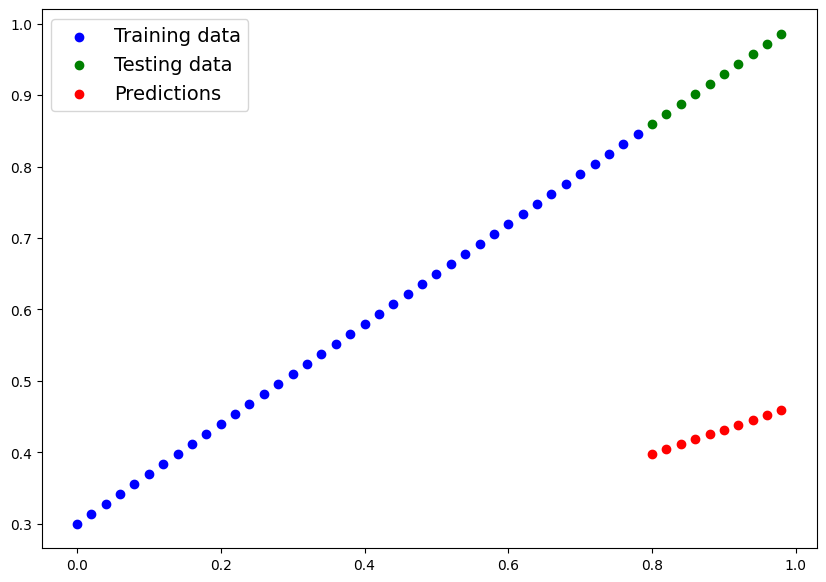

In [9]:
plot_predict(predictions=y_preds)

In [10]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

### Training first model

In [11]:
#Set up loss function
loss_fn = nn.L1Loss()

#Set up optimizer SGD
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01) #lr = learning rate, How fast the model learns

In [12]:
#Building training/testing loop
torch.manual_seed(42)

# Set the number of epochs/ num of training cycles
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    #Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad() #start with zero gradients (otherwise gradients will accumulate)

    # 4. Loss backwards/ backpropagation
    loss.backward()

    # 5. Progress the optimizer/ take a step with the optimizer
    optimizer.step()

    # Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode(): #turns off gradient calculations (saves memory and speeds up computations) and more
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening every 10 epochs
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


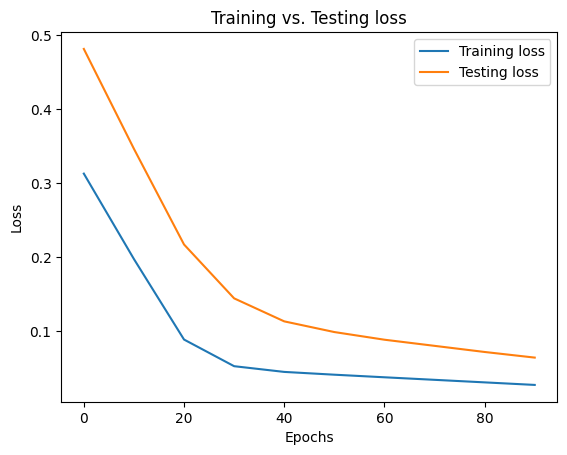

In [13]:
plt.plot(epoch_count, train_loss_values, label='Training loss')
plt.plot(epoch_count, test_loss_values, label='Testing loss')
plt.title('Training vs. Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

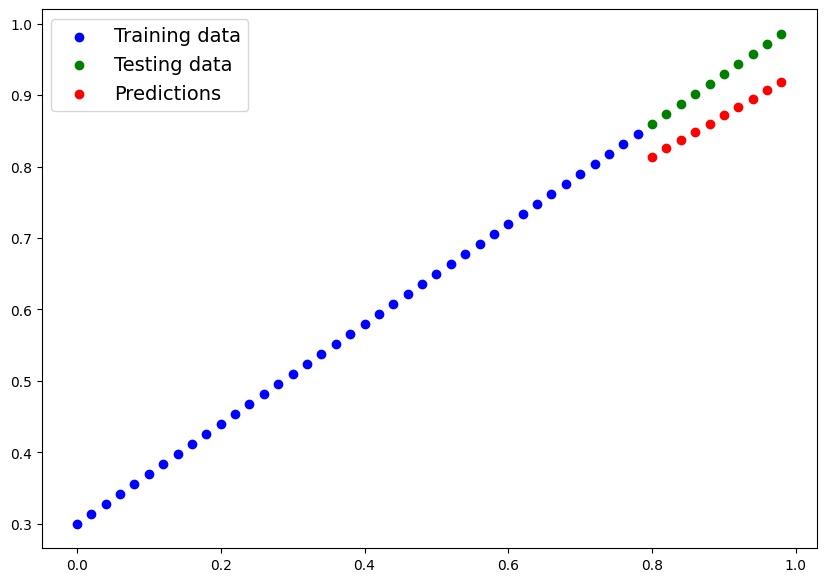

In [15]:
plot_predict(predictions=test_pred)

### Saving and loading models in pytorch
torch.save()
torch.load()
torch.nn.Module.load_state_dict()

In [17]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok=True)

# Save model

MODEL_NAME = "01_pytorch_workflow_fund.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save model state dict
print(f"Saving model state dict at: {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)


Saving model state dict at: models\01_pytorch_workflow_fund.pth


In [19]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_0.state_dict(), model_0.state_dict()

(OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))]),
 OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))]))

In [20]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_0_y_preds = loaded_model_0(X_test)

loaded_model_0_y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [21]:
model_0.eval()
with torch.inference_mode():
    model_0_y_preds = model_0(X_test)

model_0_y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [22]:
model_0_y_preds == loaded_model_0_y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting it all together


In [23]:
import torch 
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu117'

In [24]:
#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [25]:
#Data

#y = mx + b

w = 0.7
b = 0.3

start = 0
end = 1
step = 0.02

x = torch.arange(start,end, step).unsqueeze(1)
y = w*x + b
x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [27]:
#Split data into training and testing sets
tSplit = int(0.8 *len(x))
x_train, y_train = x[:tSplit], y[:tSplit]
x_test, y_test = x[tSplit:], y[tSplit:]
len(x_train), len(x_test), len(y_train), len(y_test)

(40, 10, 40, 10)

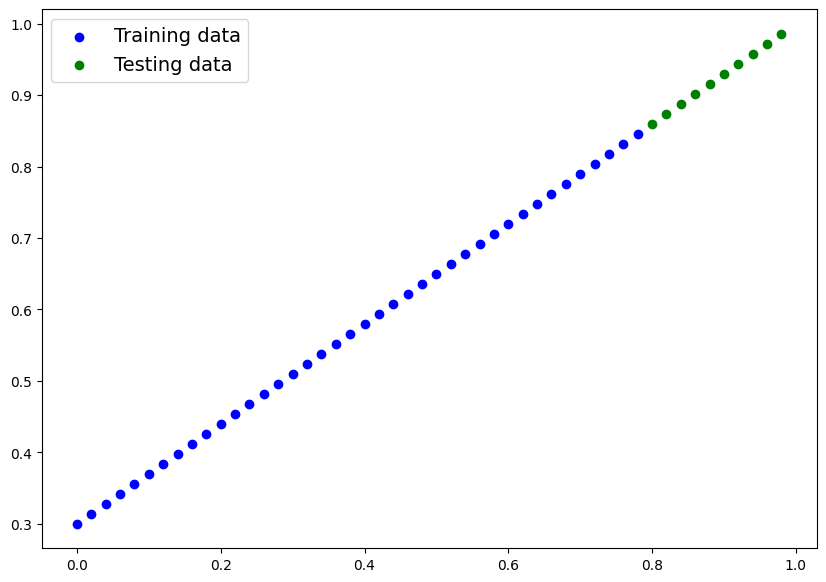

In [28]:
plot_predict(x_train, y_train, x_test, y_test)

In [36]:
#Build model subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        #Use nn.Linear to create a linear transformation of the form y = wx + b

        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    

#Set random seed
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [37]:
#Set model to device

model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [38]:
#Set up loss function

loss_fn = nn.L1Loss()

#Set up optimizer

optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [48]:
torch.manual_seed(42)


epochs = 200

#Put data on device

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    #1. Forward pass
    y_pred = model_1(x_train)

    #2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    #3. Zero gradients
    optimizer.zero_grad()

    #4. Backward pass
    loss.backward()

    #5. Step with optimizer
    optimizer.step()

    #Testing
    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(x_test)
        test_loss = loss_fn(test_pred, y_test)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
            

Epoch: 0 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 10 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 20 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 30 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 40 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 50 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 60 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 70 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 80 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 90 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 100 | MAE Train Loss: 0.010256479494273663 | MAE Test Loss: 0.00033081771107390523 
Epoch: 110

In [49]:
model_1.state_dict(), weight, bias

(OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.2925], device='cuda:0'))]),
 0.7,
 0.3)

In [51]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(x_test)
y_preds


tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]], device='cuda:0')

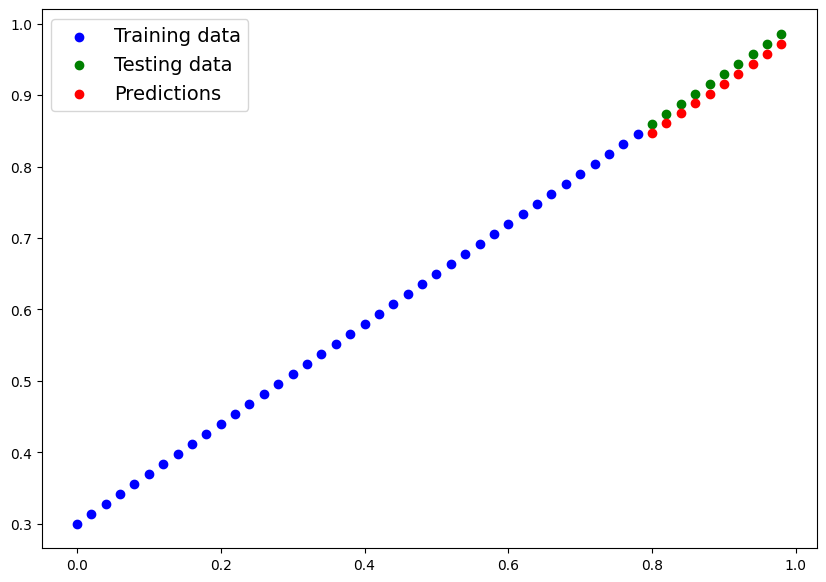

In [53]:
plot_predict(predictions=y_preds.cpu())

In [54]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_fund_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_fund_model_1.pth


In [55]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [57]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(x_test)
y_preds == loaded_model_1_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')